# Summary

Explore derivation of indicatrix and figuratrix. 

### Preliminaries

In [1]:
# Specify the parameter files for the job
import os
if 'GME_NB_PR' not in os.environ.keys():
    pr_filenames = ['IndicatrixExploration_sinbeta_eta0p5']
else:
    pr_filenames = eval(os.environ['GME_NB_PR'])
    
# Import Sympy and Numpy and set up latex inline & pretty dict printing
import sympy as sy, numpy as np
sy.init_printing(pretty_print=True,wrap_line=True)
from sympy import Matrix, Eq, lambdify, poly, \
    simplify, factor, expand, cancel, collect, expand_trig, \
    sin,cos,tan,sec, atan, Rational, sqrt, solve, Abs, N, re, im, \
    diff, pi, numer, denom
from pprint import PrettyPrinter
pp = PrettyPrinter(indent=4).pprint

# Scipy utils
from scipy.optimize import root_scalar
from scipy.linalg import norm

# Import Geomorphysics library functions, classes
from gmplib.utils import numify, export_results, e2d
from gmplib.save import create_directories, export_plots
from gmplib.parameters import import_parameters, Parameters
from gmplib.plot_utils import GraphingBase

# Import GME classes and do a wildcard (!) import of all GME symbol definitions
from gme.symbols import *
from gme.equations import Equations
# from gme.ode_raytracing import OneRaySolution
from gme.plot import OneRayPlots

# Decide where we're working and thus where to find the job parameter files
#   -  use the GME_WORKING_PATH environment variable if it's defined
#   -  otherwise, deduce that we're working in the GME notebook dir
if 'GME_WORKING_PATH' in os.environ.keys():
    working_path = os.environ['GME_WORKING_PATH']
    print(f'Fetching working path from environment variable GME_WORKING_PATH = {working_path}')
else:
    from gmplib.utils import get_pkg_path
    import gme
    working_path = get_pkg_path(gme, dirname='')
    print(f'Deducing working path from GME package location = {working_path}')
    del gme
    
# Set the path to the parameter files for this nb and report
pr_path = os.path.join(working_path,'Parameters','Theory')
pr_path, pr_filenames

Deducing working path from GME package location = /Users/colinstark/Projects/GME


('/Users/colinstark/Projects/GME/Parameters/Theory',
 ['IndicatrixExploration_sinbeta_eta0p5'])

In [2]:
# # Import Sympy and Numpy and set up latex inline & pretty dict printing
# import sympy as sy, numpy as np, os
# sy.init_printing(pretty_print=True,wrap_line=True)
# from sympy import simplify, expand, factor, collect, \
#     Rational, Eq, solve, sqrt, cbrt, Matrix, diff, pi, \
#     poly, lambdify, N, numer, denom, trigsimp, Abs, \
#     sin, cos, tan, atan
# from scipy.optimize import root_scalar
# from scipy.linalg import norm

# # Import Geomorphysics library functions
# from gmplib.utils import e2d

# # Import GME classes and do a wildcard (!) import of all GME symbol definitions
# from gme.symbols import *
# from gme.equations import Equations

# from gmplib.plot_utils import GraphingBase

In [3]:
import matplotlib as mpl, matplotlib.pyplot as plt
mpl.rc('font', size=14, family='Arial')
from matplotlib.colors import BoundaryNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
# from matplotlib.ticker import MaxNLocator

# Basics

In [4]:
parameters_dict,_ = import_parameters([pr_path], [os.path.join('..','defaults'), *pr_filenames])
evaluations = {}
evaluations_sequence = ()
pr = Parameters(parameters_dict, evaluations=evaluations, sequence=evaluations_sequence)
[pp(psubobj.__dict__) for psubobj in (pr.job, pr.model, pr.solve, pr.resolve, pr.plot, pr.save)];

{   'debug': False,
    'group_name': 'Theory',
    'short_name': 'indicatrix_exploration',
    'subtitle': '',
    'title': 'Exploration of indicatrix etc for sin(beta) erosion model, '
             'eta=1/2',
    'verbose': True,
    'very_verbose': False}
{   'beta_type': 'sin',
    'do_geodesic': False,
    'eta': 1/2,
    'h_0': 1/2,
    'ibc_type': 'concave-up',
    'kappa_h': 3/2,
    'mu': 1/4,
    't_xiv0_list': None,
    'varepsilon': 1/1000,
    'varphi_0': 300,
    'varphi_type': 'ramp',
    'x_1': 1,
    'x_h': 1,
    'x_sigma': 0.01,
    'xiv_0': 30}
{   'choice': 'Hamilton',
    'do_dense': True,
    'do_geodesic': True,
    'do_ic': False,
    'do_ip': False,
    'do_vb': False,
    'ic_res': 31,
    'ip_res': 101,
    'method': {   'Hamilton': 'DOP853',
                  'choices': ['RK45', 'RK23', 'Radau', 'DOP853', 'LSODA'],
                  'geodesic': 'LSODA'},
    'ray_n_t': 301,
    't_distribn': 2,
    't_end': 0.01,
    'vb_res': 101}
{   'do_eliminate_caustic

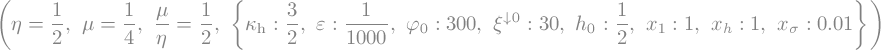

In [5]:
sub = {
        x_1: pr.model.x_1, 
        varepsilon: pr.model.varepsilon, 
        varphi_0: pr.model.varphi_0,
        xiv_0: pr.model.xiv_0,
        kappa_h: pr.model.kappa_h,
        h_0: pr.model.h_0,
        x_sigma: pr.model.x_sigma,
        x_h: pr.model.x_h
}
Eq(eta,pr.model.eta), Eq(mu,pr.model.mu), Eq(mu/eta,pr.model.mu/pr.model.eta), sub

In [6]:
# eta_ = Rational(1,2)
# sub = {
#         x_1: 1, 
#         varepsilon: Rational(1,1000), 
#         varphi_0: 300,
#         xiv_0: 30,
#         kappa_h: Rational(3,2),
#         h_0: Rational(1,2),
#         x_sigma: 0.01,
#         x_h: 1
# }
# Eq(eta,eta_), sub

In [7]:
gmeq = Equations( eta=pr.model.eta, 
                  mu=pr.model.mu, 
                  beta_type=pr.model.beta_type, 
                  varphi_type=pr.model.varphi_type, 
                  ibc_type=pr.model.ibc_type,
                  do_idtx=True,
                  do_geodesic=False, 
                  parameters=sub )

In [8]:
prefix = ('_').join([pr.job.short_name, gmeq.beta_type+'beta'])
# prefix = ('_').join([pr.job.short_name, gmeq.beta_type+'beta', gmeq.varphi_type.replace('-','')])

suffix = f'_eta{float(sy.N(gmeq.eta))}'
# suffix += f'_ratio{ float(sy.N(gmeq.mu/gmeq.eta)):0.2f}' if gmeq.mu/gmeq.eta==Rational(1,3) \
#                                     else f'_ratio{ float(sy.N(gmeq.mu/gmeq.eta)):0.1f}'
# suffix += f'_xiv{float(sy.N(pr.model.xiv_0)):1.0f}'
# suffix = (suffix if pr.model.varphi_type=='ramp' \
#             else suffix+f'_xh{float(gmes.parameters[x_h]):1.1f}').replace('.','p')

job_name = prefix+suffix.replace('.','p')
job_name

'indicatrix_exploration_sinbeta_eta0p5'

In [9]:
gr = GraphingBase()

# $F$  vs  $F^*$

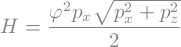

In [10]:
gmeq.H_eqn.subs({varphi_r:varphi})

In [11]:
varphi_ = 1
Eq(varphi,varphi_)

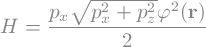

In [39]:
gmeq.H_eqn

In [12]:
H_parametric_eqn = Eq((2*gmeq.H_eqn.rhs)**2,1).subs({varphi_r:varphi_, xiv:xiv_0})
H_parametric_eqn

In [13]:
Eq(4*gmeq.H_eqn.rhs**2,1).subs({px:px_min}).subs({varphi_r:varphi})

In [14]:
if pr.model.eta==Rational(3,2):
    pz_min_eqn = Eq(pz_min,
        (solve(Eq( ((solve(Eq(4*gmeq.H_eqn.rhs**2,1)
                           .subs({varphi_r:varphi}),px**2)[2]).args[0].args[0].args[0])**2, 0)
          ,pz**4)[0])**Rational(1,4))
    px_min_eqn = Eq(px_min,
            solve(simplify(gmeq.H_eqn.subs({varphi_r:varphi})
                           .subs({pz:pz_min_eqn.rhs})).subs({H:Rational(1,2)}),px)[0] )
    tanbeta_max_eqn = Eq(tan(beta_max), ((px_min/pz_min).subs(e2d(px_min_eqn))).subs(e2d(pz_min_eqn)))
    tanbeta_max = float(N(tanbeta_max_eqn.rhs))
else:
    pz_min_eqn = Eq(pz_min, 0)
    px_min_eqn = Eq(px_min, 
                    sqrt(solve(Eq((
                    solve(Eq(4*gmeq.H_eqn.rhs**2,1).subs({varphi_r:varphi}),pz**2)[:])[0],0)
                                   ,px**2)[1]))
    tanbeta_max_eqn = Eq(tan(beta_max),sy.oo)
    tanbeta_max = None

px_min_eqn, pz_min_eqn, tanbeta_max_eqn, tanbeta_max

(Eq(p_{x_\text{min}}, 1/\varphi),
 Eq(p_{z_\text{min}}, 0),
 Eq(tan(\beta_{\text{max}}), oo),
 None)

In [15]:
px_min_ = round(float(N(px_min_eqn.rhs.subs({varphi:varphi_}))),4)
pz_min_ = round(float(N(pz_min_eqn.rhs.subs({varphi:varphi_}))),8)
px_min_, -pz_min_, np.rad2deg(np.arctan(px_min_/pz_min_)) if pz_min_>0 else None

(1.0, -0.0, None)

In [16]:
H_parametric_eqn

In [17]:
px_H_solns = [simplify(soln) for soln in solve(Eq((4*H_parametric_eqn.lhs)**2, (4*H_parametric_eqn.rhs)**2),px**2)]

In [18]:
x,z = symbols('x, z')

In [19]:
tmp = Eq((H_parametric_eqn.lhs)**2-(H_parametric_eqn.rhs)**2,0).subs({px:x, pz:z})
tmp

In [21]:
# simplify(solve(tmp,z**2)[2])

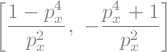

In [22]:
[simplify(soln) for soln in solve(Eq((4*H_parametric_eqn.lhs)**2, (4*H_parametric_eqn.rhs)**2),pz**2)]

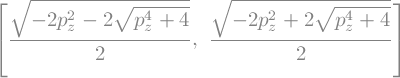

In [23]:
px_H_solns = [simplify(sqrt(soln)) for soln in solve( H_parametric_eqn ,px**2)]
px_H_solns

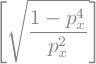

In [24]:
pz_H_solns = [simplify(sqrt(soln)).subs({Abs(px):px}) for soln in solve( H_parametric_eqn ,pz**2)]
pz_H_solns

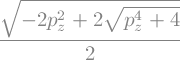

In [25]:
px_H_soln_ = [soln for soln in px_H_solns if Abs(sy.im(N(soln.subs({pz:1}))))<1e-10][0]
px_H_soln_
#  if N(Abs(sy.im(soln.subs({varphi_r:varphi__,pz:pz_}))))<1e-10

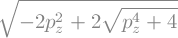

In [26]:
px_H_lambda = lambdify( [pz], simplify(px_H_soln_) )
numer(simplify(px_H_soln_))

In [43]:
if pr.model.eta==Rational(3,2):
    pz_max_ = 10**4
else:
    pz_max_ = 10**2
pz_array = -10**np.linspace(np.log10(pz_min_ if pz_min_>0 else 1e-6), np.log10(pz_max_), 1000)
px_array = px_H_lambda(pz_array)
p_array = np.vstack([px_array,pz_array]).T
modp_array = norm(p_array,axis=0)
# np.rad2deg(np.arctan(-px_array[0]/pz_array[0])), np.rad2deg(np.arctan(gmeq.tanbeta_crit)), \
#     Eq(beta_crit, round(N(sy.deg(atan(gmeq.tanbeta_crit_eqn.rhs))),2))
tanbeta_crit = float(N(gmeq.tanbeta_crit_eqn.rhs))
del px_array, pz_array
p_infc_array = p_array[np.abs(p_array[:,0]/p_array[:,1])<tanbeta_crit]
p_supc_array = p_array[np.abs(p_array[:,0]/p_array[:,1])>=tanbeta_crit]

In [28]:
px_poly_eqn = sy.poly(H_parametric_eqn)
px_poly_lambda = lambdify( [px,pz], px_poly_eqn.as_expr() )
dpx_poly_lambda = lambdify( [px,pz], diff(px_poly_eqn.as_expr(),px) )

px_solutions = lambda px_guess_: np.array([
    (root_scalar( px_poly_lambda, args=(pz_),fprime=dpx_poly_lambda, 
                 method='newton', x0=px_guess_ )).root for pz_ in p_array[:,1]])
px_newton_array = px_solutions(10)

In [29]:
pz_ = 2
px_ = px_H_lambda(pz_)

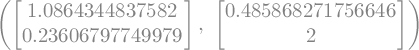

In [30]:
v_from_gstar_lambda_tmp = lambdify((px,pz),
                N(gmeq.gstar_varphi_pxpz_eqn.subs({varphi_r:varphi_}).rhs*Matrix([px,pz])))
v_from_gstar_lambda = lambda px_,pz_: (v_from_gstar_lambda_tmp(px_,pz_)).flatten()
Matrix(v_from_gstar_lambda(px_,pz_)),(Matrix([px_,pz_]))

In [31]:
v_ = (v_from_gstar_lambda(px_,pz_))
np.dot(np.array([px_,pz_]),v_)

In [32]:
dp_supc_array = p_array[(-p_array[:,0]/p_array[:,1])>=gmeq.tanbeta_crit]

In [33]:
v_lambda = lambda pa: np.array([(v_from_gstar_lambda(px_,pz_)) for px_,pz_ in pa])
v_infc_array = v_lambda(p_infc_array)
v_supc_array = v_lambda(p_supc_array)
v_array = v_lambda(p_array)

# Plots

In [34]:
def Fstar_F_rectlinear(do_zoom=False):
    fig = gr.create_figure(job_name+'_Fstar_F_rectlinear'+('_zoom' if do_zoom else ''), fig_size=(7,9))
    eta_ = pr.model.eta
#     eta_xy_label = [0,0]
#     plt.xlim(0,2)
#     plt.ylim(-4,0.6)
    if do_zoom:
        if eta_==Rational(3,2):
            plt.xlim(0.98,1.07)
            plt.ylim(0.15,0.23)
            eta_xy_label = [0.2,0.85]
        else:
            plt.xlim(0.7,1.2)
            plt.ylim(-0.4,0)
            eta_xy_label = [0.8,0.8]
    else:
        if eta_==Rational(3,2):
            plt.xlim(0,2)
            plt.ylim(-4,0.6)
            eta_xy_label = [0.7,0.8]
        else:
            plt.xlim(0,2.5)
            plt.ylim(-2,0)
            eta_xy_label = [0.8,0.7]

    # Critical, bounding angles
    # pz_max_ = p_array[-1,1]
    if eta_==Rational(3,2):
        pz_max_ = -1.5
    else:
        pz_max_ = -1.5
    px_abmax_ = -pz_max_*(tanbeta_max if tanbeta_max is not None else 1)
    pz_abmax_ = pz_max_
    vx_abmax_,vz_abmax_ = v_from_gstar_lambda(px_abmax_,pz_abmax_)
    px_abcrit_ = -pz_max_*gmeq.tanbeta_crit
    pz_abcrit_ = pz_max_
    vx_abcrit_,vz_abcrit_ = v_from_gstar_lambda(px_abcrit_,pz_abcrit_)

    # Lines visualizing critical, bounding angles: ray velocity
    if eta_==Rational(3,2):
        plt.plot([0,vx_abmax_],[0,vz_abmax_], 
                 '-', color='r', alpha=0.4, lw=2, label=r'$\alpha_{\mathrm{lim}}$')

    # Indicatrix aka F=1 for rays
    plt.plot(v_supc_array[:,0],v_supc_array[:,1], 'Red', lw=2, ls='-', 
             label=r'$F=1$,  $\beta\geq\beta_\mathrm{c}$')
    plt.plot([0,vx_abcrit_],[0,vz_abcrit_], 
             '-.', color='DarkRed', lw=1, label=r'$\alpha_{\mathrm{c}}$')
    plt.plot(v_infc_array[:,0],v_infc_array[:,1], 'DarkRed', lw=1 if eta_==Rational(3,2) and not do_zoom else 2, 
             ls='-', 
             label=r'$F=1$,  $\beta<\beta_\mathrm{c}$')

    # Lines visualizing critical, bounding angles: normal slowness
    if eta_==Rational(3,2) and not do_zoom:
        plt.plot(np.array([0,px_abmax_]),[0,pz_abmax_], 
                 '-b', alpha=0.4, lw=1.5, label=r'$\beta_{\mathrm{max}}$')

    # Figuratrix aka F*=1 for surfaces
    if not do_zoom:
        plt.plot(p_supc_array[:,0],p_supc_array[:,1], 'Blue', lw=2, ls='-', 
                 label=r'$F^*\!\!=1$,  $\beta\geq\beta_\mathrm{c}$')
        plt.plot([0,px_abcrit_],[0,pz_abcrit_], 
                 '--', color='DarkBlue', lw=1, label=r'$\beta_{\mathrm{c}}$')
        plt.plot(p_infc_array[:,0],p_infc_array[:,1], 'DarkBlue', lw=2, ls='-', 
                 label=r'$F^*\!\!=1$,  $\beta<\beta_\mathrm{c}$')

    # px_, pz_ = p_array[0]
    # vx_,vz_ = v_from_gstar_lambda(px_,pz_)
    # plt.plot([px_],[pz_], 'o', color='DarkBlue', ms=9, fillstyle='none')
    # plt.plot([vx_],[vz_], 'o', color='DarkRed', ms=9, fillstyle='none')

    pz_ = -float(solve(H_parametric_eqn.subs({px:pz*(gmeq.tanbeta_crit)}),pz)[0])
    px_ = px_H_lambda(pz_)
    vx_,vz_ = v_from_gstar_lambda(px_,pz_)
    if eta_!=Rational(3,2):
        plt.plot([vx_],[-vz_], 'o', color='DarkRed', ms=5)
    if not do_zoom:
        plt.plot([px_],[-pz_], 'o', color='DarkBlue', ms=5)

    plt.xlabel(r'$p_x$ (for $F^*$)  or  $v^x$ (for $F$)', fontsize=14)
    plt.ylabel(r'$p_z$ (for $F^*$)  or  $v^z$ (for $F$)', fontsize=14)

    axes = plt.gca()
    axes.set_aspect(1)    
    plt.text(*eta_xy_label, rf'$\eta={gmeq.eta}$', transform=axes.transAxes,
             horizontalalignment='center', verticalalignment='center',
             fontsize=15, color='k')

    if eta_==Rational(3,2):
        if do_zoom:
            plt.legend(loc='lower right')
        else:
            plt.legend(loc='lower left')
    else:
        if do_zoom:
            plt.legend(loc='upper left')
        else:
            plt.legend(loc='lower right')

    plt.grid(True, ls=':')

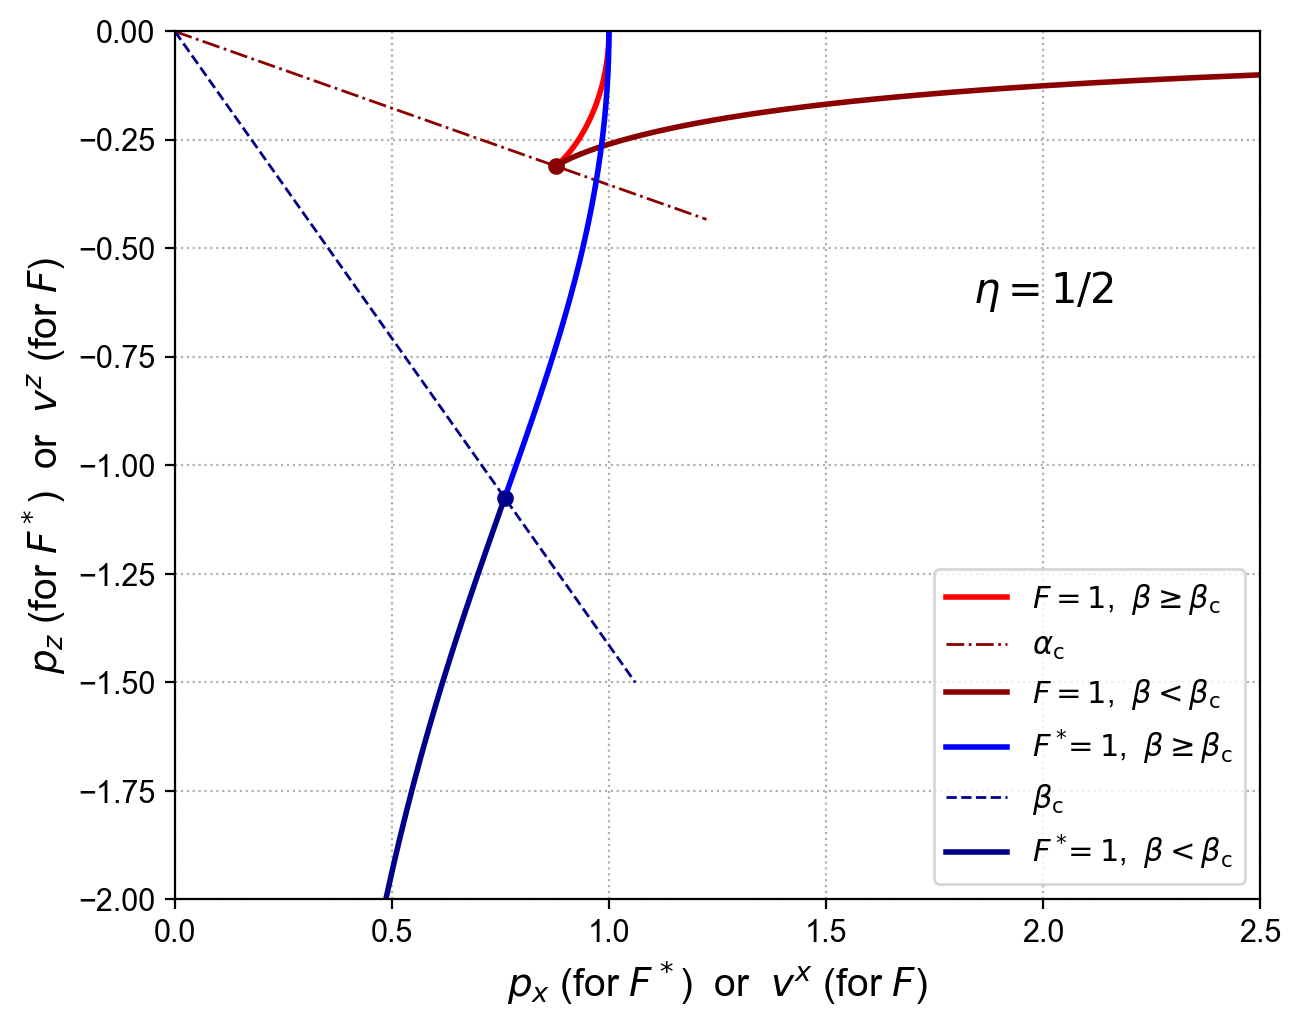

In [35]:
Fstar_F_rectlinear(do_zoom=False)

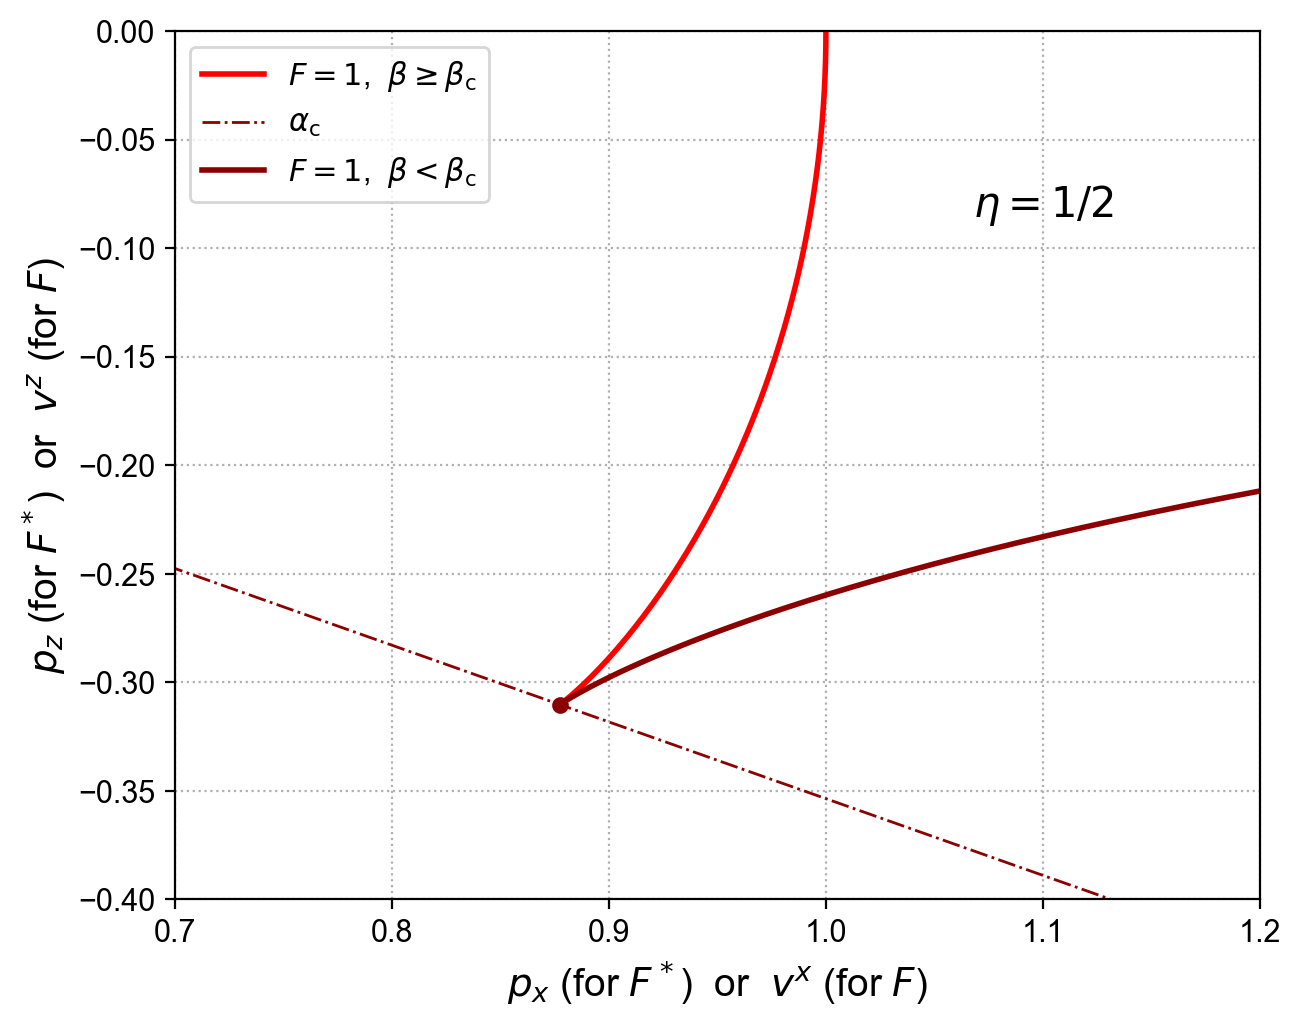

In [36]:
Fstar_F_rectlinear(do_zoom=True)

In [37]:
def Fstar_F_polar():
    fig = gr.create_figure(job_name+'_Fstar_F_polar', fig_size=(7,7))
    eta_ = pr.model.eta

    if eta_>1:
        r_min_ = 0.1
        r_max_ = 100
        scale_fn = lambda a: np.log10(a)
        alpha_fn = lambda a: np.pi-a
    else:
        r_min_ = 0.1
        r_max_ = 10
        scale_fn = lambda a: np.log10(a)
        alpha_fn = lambda a: a
    v_scale_fn = lambda v: scale_fn(v)*1    
    
    # Lines visualizing critical, bounding angles: ray velocity
    if eta_==Rational(3,2):
        plt.polar([np.pi/2+(np.arctan(gmeq.tanalpha_crit))]*2, [scale_fn(r_min_),scale_fn(r_max_)], 
                  '-', color='r', alpha=0.4, lw=2, label=r'$\alpha_{\mathrm{lim}}$')
    plt.polar(alpha_fn(np.arcsin(v_supc_array[:,0]/norm(v_supc_array, axis=1))),
              v_scale_fn(norm(v_supc_array, axis=1)), 'Red',
              label=r'$F=1$,  $\beta\geq\beta_\mathrm{c}$')
    plt.polar([np.pi/2+(np.arctan(gmeq.tanalpha_crit))]*2, [scale_fn(r_min_),scale_fn(r_max_)], 
              '-.', color='DarkRed', lw=1, label=r'$\alpha_{\mathrm{c}}$')
    plt.polar(alpha_fn(np.arcsin(v_infc_array[:,0]/norm(v_infc_array, axis=1))),
              v_scale_fn(norm(v_infc_array, axis=1)), 'DarkRed', lw=None if eta_==Rational(3,2) else None,
              label=r'$F=1$,  $\beta<\beta_\mathrm{c}$')
    
    unit_circle_array = np.array([[theta_,1] for theta_ in np.linspace(0,(np.pi/2)*1.2,100)])
    plt.polar(unit_circle_array[:,0], scale_fn(unit_circle_array[:,1]), 
              '-', color='g', lw=1, label='unit circle')

    if eta_>1:
        plt.polar([np.arctan(tanbeta_max)]*2, [scale_fn(r_min_),scale_fn(r_max_)], 
                  '-', color='b', alpha=0.3, lw=1.5, label=r'$\beta_{\mathrm{max}}$')
    plt.polar(np.arcsin(p_supc_array[:,0]/norm(p_supc_array, axis=1)),
                  scale_fn(norm(p_supc_array, axis=1)), 'Blue',
                     label=r'$F^*\!\!=1$,  $\beta\geq\beta_\mathrm{c}$')
    plt.polar([np.arctan(gmeq.tanbeta_crit)]*2, [scale_fn(r_min_),scale_fn(r_max_)], 
              '--', color='DarkBlue', lw=1, label=r'$\beta_{\mathrm{c}}$')
    plt.polar(np.arcsin(p_infc_array[:,0]/norm(p_infc_array, axis=1)),
                  scale_fn(norm(p_infc_array, axis=1)), 'DarkBlue',
                     label=r'$F^*\!\!=1$,  $\beta<\beta_\mathrm{c}$')

    plt.polar(
        (np.arcsin(p_supc_array[-1,0]/norm(p_supc_array[-1]))
         +np.arcsin(p_infc_array[0,0]/norm(p_infc_array[0])))/2,
        (scale_fn(norm(p_infc_array[0]))+scale_fn(norm(p_supc_array[-1])))/2, 
              'o', color='DarkBlue')
    
    axes = plt.gca()
    axes.set_theta_zero_location('S')
    horiz_label = r'$\log_{10}{p}$  or  $\log_{10}{v}$'
    vert_label = r'$\log_{10}{v}$  or  $\log_{10}{p}$'

    if eta_>1:
        theta_max_ = 20
        axes.set_thetamax(90+theta_max_)
        axes.text(np.deg2rad(85+theta_max_),0.5, vert_label,
                    rotation=theta_max_, ha='center', va='bottom', fontsize=15)
        axes.text(np.deg2rad(-8),1.2, horiz_label,
                    rotation=90, ha='right', va='bottom', fontsize=15)
        theta_list = [0, 1/6, 2/6, 3/6, np.deg2rad(110)/np.pi]
        xtick_labels = [
            r'$\beta=0^{\!\circ}$',
            r'$\beta=30^{\!\circ}$',
            r'$\beta=60^{\!\circ}$',
            r'$\alpha=0^{\!\circ}$',
            r'$\alpha=20^{\!\circ}$',
        ]
        eta_xy_label = [1.15,0.9]
        legend_xy = [1,0]
        plt.text(*[(np.pi/2)*1.07,0.4], 'convex', #transform=axes.transAxes,
             horizontalalignment='center', verticalalignment='center',
             rotation=8, fontsize=15, color='DarkRed')
        plt.text(*[(np.pi/3)*0.925,0.5], 'convex', #transform=axes.transAxes,
             horizontalalignment='center', verticalalignment='center',
             rotation=-35, fontsize=15, color='b')
        plt.text(*[(np.pi/6)*0.7,0.85], 'convex', #transform=axes.transAxes,
             horizontalalignment='center', verticalalignment='center',
             rotation=68, fontsize=15, color='DarkBlue')
    else:
        theta_max_ = 0
        axes.set_thetamax(90+theta_max_)
        axes.text(np.deg2rad(92+theta_max_),axes.get_rmax()/5, vert_label,
                    rotation=theta_max_, ha='right', va='bottom', fontsize=15)
        axes.text(np.deg2rad(-8),axes.get_rmax()/5, horiz_label,
                    rotation=90, ha='right', va='bottom', fontsize=15)
        theta_list = [0, 1/6, 2/6, 3/6]
        xtick_labels = [
            r'$\beta=0^{\!\circ}$',
            r'$\beta=30^{\!\circ}$',
            r'$\beta=60^{\!\circ}\!\!,\, \alpha=-30^{\!\circ}$',
            r'$\beta=90^{\!\circ}\!\!,\, \alpha=0^{\!\circ}$',
        ]
        eta_xy_label = [1.2,0.75]
        legend_xy = [0.9,0]
        plt.text(*[(np.pi/2)*0.94,0.4], 'concave', #transform=axes.transAxes,
             horizontalalignment='center', verticalalignment='center',
             rotation=11, fontsize=15, color='DarkRed')
        plt.text(*[(np.pi/2)*0.9,-0.07], 'convex', #transform=axes.transAxes,
             horizontalalignment='center', verticalalignment='center',
             rotation=72, fontsize=13, color='r')
        plt.text(*[(np.pi/4)*1.2,0.12], 'convex', #transform=axes.transAxes,
             horizontalalignment='center', verticalalignment='center',
             rotation=60, fontsize=15, color='b')
        plt.text(*[(np.pi/6)*0.5,0.4], 'concave', #transform=axes.transAxes,
             horizontalalignment='center', verticalalignment='center',
             rotation=50, fontsize=15, color='DarkBlue')
        plt.polar(alpha_fn(np.arcsin(v_supc_array[:,0]/norm(v_supc_array, axis=1))),
                  v_scale_fn(norm(v_supc_array, axis=1)), 'Red')
        
    plt.polar(
        alpha_fn((np.arcsin(v_supc_array[-1,0]/norm(v_supc_array[-1]))
                  +np.arcsin(v_infc_array[0,0]/norm(v_infc_array[0])))/2),
        (v_scale_fn(norm(v_infc_array[0]))+v_scale_fn(norm(v_supc_array[-1])))/2, 
              'o', color='DarkRed')


    xtick_posns = [np.pi*theta_ for theta_ in theta_list]
    plt.xticks(xtick_posns, xtick_labels, ha='left', fontsize=15);

    plt.text(*eta_xy_label, rf'$\eta={gmeq.eta}$', transform=axes.transAxes,
             horizontalalignment='center', verticalalignment='center',
             fontsize=18, color='k')
    plt.legend(loc=legend_xy)
        
    axes.tick_params(axis='x', pad=0, left=True, length=5, width=1, direction='out')
    
    axes.set_aspect(1)    
    axes.set_rmax(scale_fn(r_max_))
    axes.set_rmin(scale_fn(r_min_))
    axes.set_thetamin(0)
    plt.grid(False, ls=':');

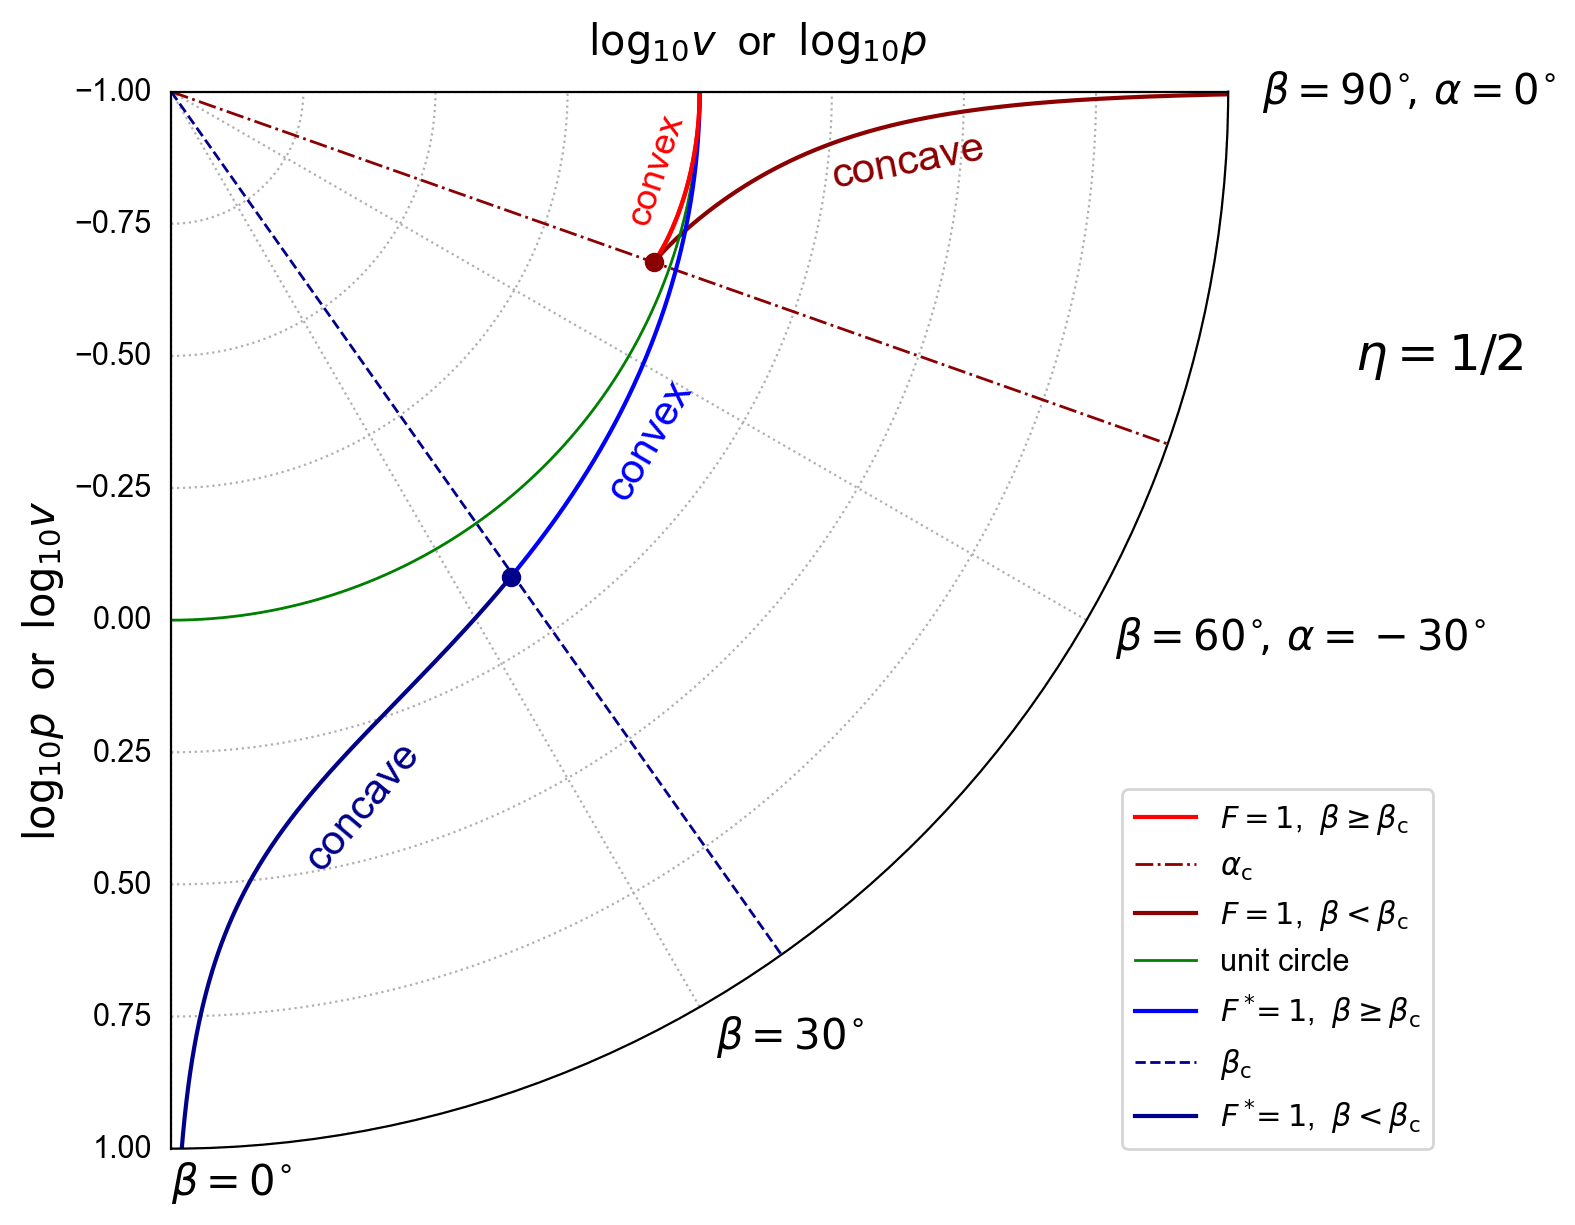

In [38]:
Fstar_F_polar()

# Save

In [ ]:
plots_dir = create_directories(pr.save.figs_path, pr.job.group_name)
export_plots( gr.fdict, plots_dir, pr.save.figs_format, suffix='' )